In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bethe_lattice import bethe_green_function
from mesh import Meshiw, Meshitau
from green_function import Giw, make_Gtau_from_Giw
from monte_carlo import monte_carlo_sampling

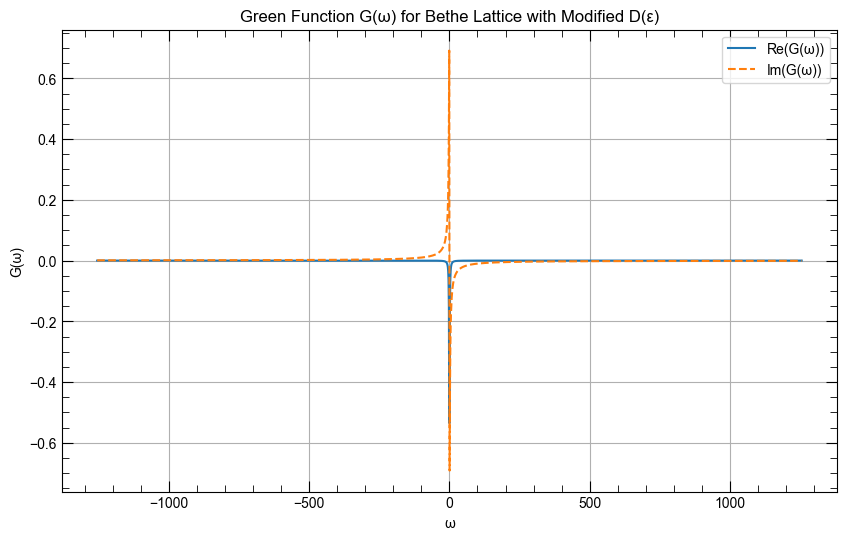

In [2]:
# パラメータの設定
W = 1.0  # 帯域幅
D_0 = 2.0 / np.pi  # 正規化定数 (D_0 = 2/π を仮定)
delta = 0.00  # 正の無限小量
beta = 5  # 逆温度
U = 0.7  # 相互作用

# マツバラ周波数の定義
meshiw = Meshiw(beta, 1000)

# グリーン関数の計算
giw_values = np.array(
    [bethe_green_function(1.0j * omega, W, D_0, delta) for omega in meshiw.iw]
)
giw_values = 1 / (1 / giw_values - U)
giw = Giw(meshiw, giw_values)

# 結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(giw.meshiw.iw, giw.giw_value.real, label="Re(G(ω))")
plt.plot(giw.meshiw.iw, giw.giw_value.imag, label="Im(G(ω))", linestyle="dashed")
plt.xlabel("ω")
plt.ylabel("G(ω)")
plt.title("Green Function G(ω) for Bethe Lattice with Modified D(ε)")
plt.legend()
plt.grid(True)
plt.show()

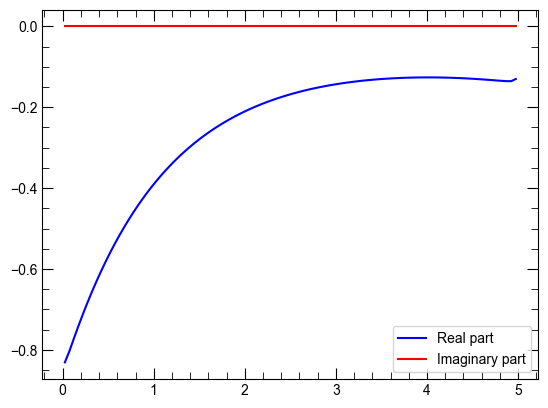

In [3]:
# Gtauへの変換
gtau = make_Gtau_from_Giw(giw, 100)

# プロット (imaginary time)
fig, ax = plt.subplots()
ax.plot(gtau.meshitau.tau, np.real(gtau.gtau_value), "b-", label="Real part")
ax.plot(gtau.meshitau.tau, np.imag(gtau.gtau_value), "r-", label="Imaginary part")
ax.legend()

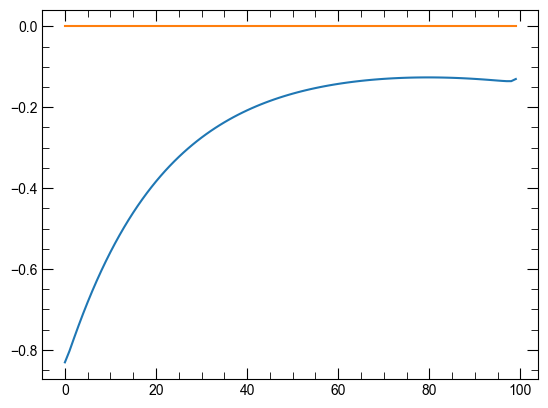

In [4]:
# g0_tauの計算
n_tau = 100
gtau = make_Gtau_from_Giw(giw, n_tau)
g0_tau = np.zeros((n_tau, n_tau), dtype=complex)
delta_tau = beta / n_tau
for i in range(n_tau):
    for j in range(n_tau):
        g0_tau[i, j] = gtau.gtau_value[i - j] * np.where(
            i - j > 0, 1, np.where(i - j < 0, -1, 1)
        )
# g0_tauのプロット
fig, ax = plt.subplots()
ax.plot(g0_tau[:, 0].real, label="Real part")
ax.plot(g0_tau[:, 0].imag, label="Imaginary part")

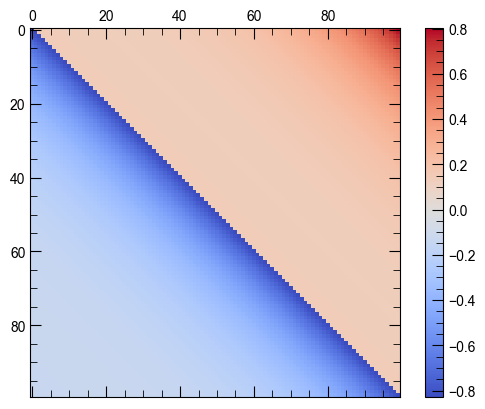

In [5]:
# g0_tauの２次元のヒートマップを描画
fig, ax = plt.subplots()
cax = ax.matshow(g0_tau.real, cmap="coolwarm")
fig.colorbar(cax)
plt.show()

In [6]:
# 相互作用の設定
U = 0.7
n_warmup = 1000
n_cycle = 5000
g_up, g_dn = monte_carlo_sampling(
    g0_tau, U, delta_tau, n_tau, n_warmup=n_warmup, n_cycle=n_cycle
)

Warmup:   0%|          | 0/1000 [00:00<?, ?it/s]

Monte Carlo Sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

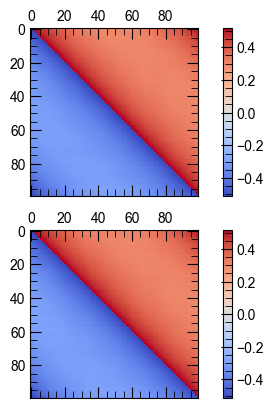

In [7]:
# 平均化されたグリーン関数のプロット
fig, ax = plt.subplots(2, 1)

cax = ax[0].matshow(g_up.real, cmap="coolwarm")
fig.colorbar(cax, ax=ax[0])

cax = ax[1].matshow(g_dn.real, cmap="coolwarm")
fig.colorbar(cax, ax=ax[1])

plt.show()

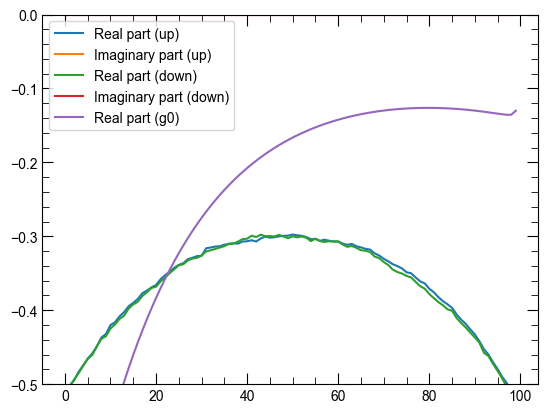

In [8]:
fig, ax = plt.subplots()
ax.plot(g_up[:, 0].real, label="Real part (up)")
ax.plot(g_up[:, 0].imag, label="Imaginary part (up)")
ax.plot(g_dn[:, 0].real, label="Real part (down)")
ax.plot(g_dn[:, 0].imag, label="Imaginary part (down)")
ax.plot(g0_tau[:, 0].real, label="Real part (g0)")
ax.set_ylim(-0.5, 0.0)
ax.legend()
plt.show()

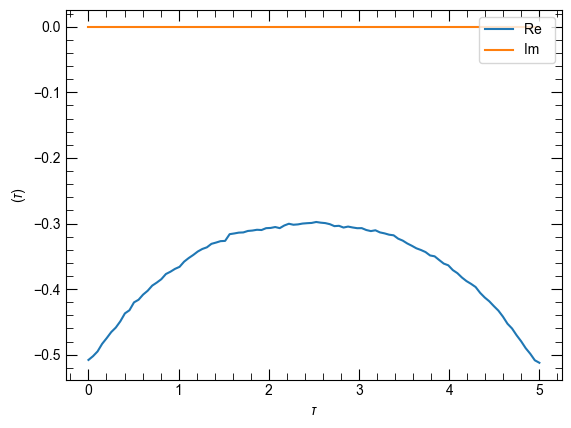

In [9]:
from triqs.gf import Gf
from triqs.plot.mpl_interface import oplot, plt

# A uniform real-frequency mesh on a given interval
from triqs.gf import MeshReFreq, MeshImFreq, MeshImTime

tau_mesh = MeshImTime(beta=beta, S="Fermion", n_tau=n_tau)
G = Gf(mesh=tau_mesh, target_shape=[])
G.data[0] = g_up[0, 0]
for i in range(n_tau):
    G.data[i] = g_up[i, 0]
oplot(G)

In [10]:
err = 1.0e-5
from triqs_maxent import *

tm = TauMaxEnt(cost_function="bryan", probability="normal")
tm.set_G_tau(G)
tm.set_error(10 * err)
res = tm.run()

2024-12-15 13:20:22.392554
MaxEnt run
TRIQS application maxent
Copyright(C) 2018 Gernot J. Kraberger
Copyright(C) 2018 Simons Foundation
Authors: Gernot J. Kraberger and Manuel Zingl
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistributeit under certain conditions; see file LICENSE.
Please cite this code and the appropriate original papers (see documentation).

Minimal chi2: 13621.835219492928
scaling alpha by a factor 100 (number of data points)
alpha[ 0] =   2.00000000e+03, chi2 =   4.08145657e+04, n_iter=      81 
alpha[ 1] =   1.05203071e+03, chi2 =   4.06016699e+04, n_iter=      50 
alpha[ 2] =   5.53384306e+02, chi2 =   4.04028932e+04, n_iter=      70 
alpha[ 3] =   2.91088642e+02, chi2 =   4.02265718e+04, n_iter=     108 


Starting serial run at: 2024-12-15 13:20:22.370989


alpha[ 4] =   1.53117095e+02, chi2 =   4.00938430e+04, n_iter=     149 
alpha[ 5] =   8.05419429e+01, chi2 =   4.00203418e+04, n_iter=     194 
alpha[ 6] =   4.23662987e+01, chi2 =   3.99916075e+04, n_iter=     231 
alpha[ 7] =   2.22853236e+01, chi2 =   3.99814109e+04, n_iter=     279 
alpha[ 8] =   1.17224224e+01, chi2 =   3.99763563e+04, n_iter=     350 
alpha[ 9] =   6.16617416e+00, chi2 =   3.99732752e+04, n_iter=     444 
alpha[10] =   3.24350229e+00, chi2 =   3.99724463e+04, n_iter=     336 
alpha[11] =   1.70613200e+00, chi2 =   3.99722728e+04, n_iter=     200 
alpha[12] =   8.97451631e-01, chi2 =   3.99722029e+04, n_iter=     245 
alpha[13] =   4.72073337e-01, chi2 =   3.99721787e+04, n_iter=     340 
alpha[14] =   2.48317824e-01, chi2 =   3.99721760e+04, n_iter=     256 
alpha[15] =   1.30618988e-01, chi2 =   3.99721760e+04, n_iter=      40 
alpha[16] =   6.87075933e-02, chi2 =   3.99721760e+04, n_iter=       6 
alpha[17] =   3.61412490e-02, chi2 =   3.99721760e+04, n_iter=  

('Curvature: ', 4)
('LineFit: ', 4)
('Classic: ', 14)


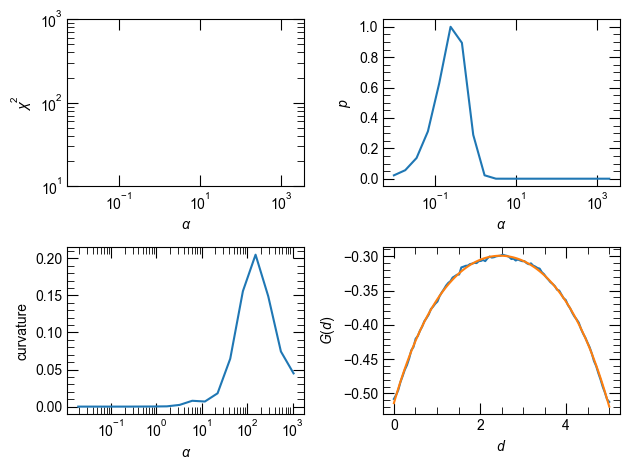

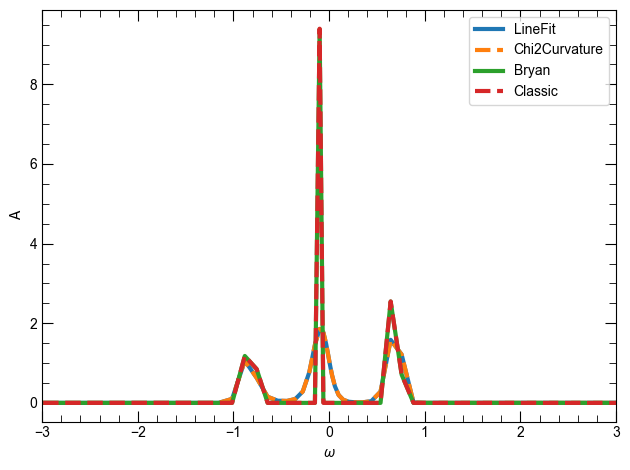

In [11]:
from triqs.plot.mpl_interface import oplot

fig1 = plt.figure()
# chi2(alpha) and linefit
plt.subplot(2, 2, 1)
res.analyzer_results["LineFitAnalyzer"].plot_linefit()
res.plot_chi2()
plt.ylim(1e1, 1e3)
# curvature(alpha)
plt.subplot(2, 2, 3)
res.analyzer_results["Chi2CurvatureAnalyzer"].plot_curvature()
# probablity(alpha)
plt.subplot(2, 2, 2)
res.plot_probability()
# backtransformed G_rec(tau) and original G(tau)
# by default (plot_G=True) also original G(tau) is plotted
plt.subplot(2, 2, 4)
res.plot_G_rec(alpha_index=5)
plt.tight_layout()

# spectral function A
fig2 = plt.figure()
# oplot(G_w, mode='S', color='k', lw=3, label='Original Model')
plt.plot(
    res.omega,
    res.analyzer_results["LineFitAnalyzer"]["A_out"],
    "-",
    lw=3,
    label="LineFit",
)
plt.plot(
    res.omega,
    res.analyzer_results["Chi2CurvatureAnalyzer"]["A_out"],
    "--",
    lw=3,
    label="Chi2Curvature",
)
plt.plot(
    res.omega, res.analyzer_results["BryanAnalyzer"]["A_out"], "-", lw=3, label="Bryan"
)
plt.plot(
    res.omega,
    res.analyzer_results["ClassicAnalyzer"]["A_out"],
    "--",
    lw=3,
    label="Classic",
)

plt.legend()
plt.xlim(-3, 3)
# plt.ylim(0, 0.6)
plt.ylabel("A")
plt.xlabel(r"$\omega$")
plt.tight_layout()

# print the optimal alpha-values
print(("Curvature: ", res.analyzer_results["Chi2CurvatureAnalyzer"]["alpha_index"]))
print(("LineFit: ", res.analyzer_results["LineFitAnalyzer"]["alpha_index"]))
print(("Classic: ", res.analyzer_results["ClassicAnalyzer"]["alpha_index"]))

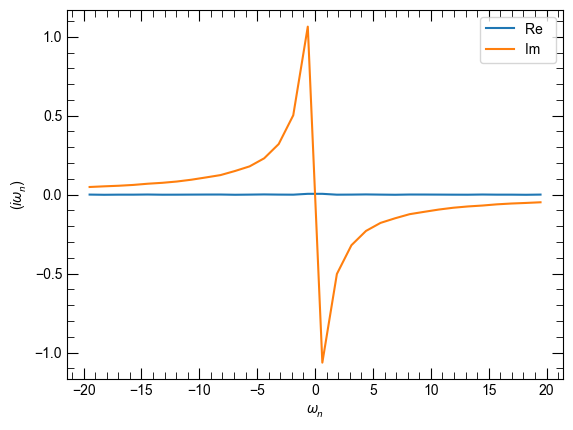

In [12]:
Giw2 = make_gf_from_fourier(G)
oplot(Giw2)